In [1]:
# imports

!pip install feature-engine
!pip install livelossplot

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.graph_objects as go
from pandas import errors
from scipy.spatial.distance import hamming
from scipy import stats
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import KBinsDiscretizer
from feature_engine.discretisation import EqualFrequencyDiscretiser
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import BatchNormalization, Conv2D, MaxPooling2D, Activation, Dropout, Lambda, Dense, Flatten, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.applications.vgg16 import preprocess_input
from tensorflow.keras.applications.vgg16 import VGG16
from livelossplot import PlotLossesKerasTF
from sklearn.metrics import confusion_matrix, classification_report, r2_score
from PIL import Image
from IPython.display import display
import cv2
import math
import warnings


warnings.filterwarnings('ignore')


     |████████████████████████████████| 205 kB 902 kB/s            


In [2]:
file_path = "../input/utkfacedata-annotations/utk_annotations.csv"
column_names = ['filename']


In [3]:
df = pd.read_csv(file_path, names=column_names)  # reading data


In [4]:
df.head()  # sneak peak of data


,filename
0,100_0_0_20170112213500903.jpg.chip.jpg
1,100_0_0_20170112215240346.jpg.chip.jpg
2,100_1_0_20170110183726390.jpg.chip.jpg
3,100_1_0_20170112213001988.jpg.chip.jpg
4,100_1_0_20170112213303693.jpg.chip.jpg


In [5]:
df.info()  # concise summary of data


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23709 entries, 0 to 23708
Data columns (total 1 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   filename  23709 non-null  object
dtypes: object(1)
memory usage: 185.4+ KB


In [6]:
def convert_int(x):
    try:
        return int(x)
    except ValueError:
        return np.nan


In [7]:
df['filepath'] = df.filename.apply(lambda x: "../input/utkface-new/UTKFace/"+x)


In [8]:
df['age'] = df.filename.apply(lambda x: convert_int(x.split('_')[0]))


In [9]:
df['gender'] = df.filename.apply(lambda x: convert_int(x.split('_')[1]))


In [10]:
df['race'] = df.filename.apply(lambda x: convert_int(x.split('_')[-2]))


In [11]:
df['date&time'] = pd.to_datetime(df.filename.apply(lambda x: x.split(
    '_')[-1].split('.')[0]), format='yyyymmddHHMMSSFFF', errors='ignore')


In [12]:
df.dropna(inplace=True)


In [13]:
df.head()


,filename,filepath,age,gender,race,date&time
0,100_0_0_20170112213500903.jpg.chip.jpg,../input/utkface-new/UTKFace/100_0_0_201701122...,100.0,0.0,0.0,20170112213500903
1,100_0_0_20170112215240346.jpg.chip.jpg,../input/utkface-new/UTKFace/100_0_0_201701122...,100.0,0.0,0.0,20170112215240346
2,100_1_0_20170110183726390.jpg.chip.jpg,../input/utkface-new/UTKFace/100_1_0_201701101...,100.0,1.0,0.0,20170110183726390
3,100_1_0_20170112213001988.jpg.chip.jpg,../input/utkface-new/UTKFace/100_1_0_201701122...,100.0,1.0,0.0,20170112213001988
4,100_1_0_20170112213303693.jpg.chip.jpg,../input/utkface-new/UTKFace/100_1_0_201701122...,100.0,1.0,0.0,20170112213303693


In [14]:
# mapping categorical data to numerical
gender_mapper = {0: 'male', 1: 'female'}
race_mapper = {0: 'white', 1: 'black', 2: 'asian', 3: 'indian', 4: 'others'}

df.gender = df.gender.map(gender_mapper)
df.race = df.race.map(race_mapper)

df.head()


,filename,filepath,age,gender,race,date&time
0,100_0_0_20170112213500903.jpg.chip.jpg,../input/utkface-new/UTKFace/100_0_0_201701122...,100.0,male,white,20170112213500903
1,100_0_0_20170112215240346.jpg.chip.jpg,../input/utkface-new/UTKFace/100_0_0_201701122...,100.0,male,white,20170112215240346
2,100_1_0_20170110183726390.jpg.chip.jpg,../input/utkface-new/UTKFace/100_1_0_201701101...,100.0,female,white,20170110183726390
3,100_1_0_20170112213001988.jpg.chip.jpg,../input/utkface-new/UTKFace/100_1_0_201701122...,100.0,female,white,20170112213001988
4,100_1_0_20170112213303693.jpg.chip.jpg,../input/utkface-new/UTKFace/100_1_0_201701122...,100.0,female,white,20170112213303693


In [15]:
df = df.astype({
    'age': int,
    'gender': str,
    'race': str
})


In [16]:
df.nunique()  # distinct elements in column axis


filename     23708
filepath     23708
age            104
gender           2
race             5
date&time    23482
dtype: int64

In [17]:
df = df.sample(frac=1)  # randomizing data


In [18]:
age_bins = [0, 10, 20, 30, 40, 60, 80, np.inf]
age_ranges = ['0-10', '10-20', '20-30', '30-40', '40-60', '60-80', '80-200']
age_binned = pd.cut(df['age'], age_bins, labels=age_ranges)
genders = sorted(gender_mapper.values())
races = sorted(race_mapper.values())


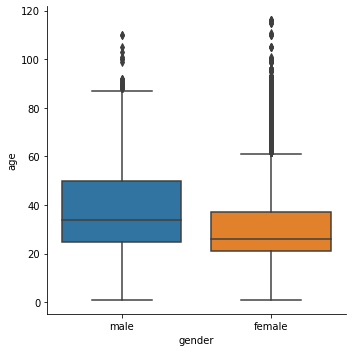

In [19]:
# box plot for age and gender
sns.catplot(x="gender", y="age", kind="box", data=df)


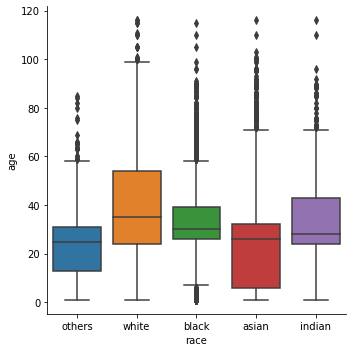

In [20]:
# box plot for age and race
sns.catplot(x="race", y="age", kind="box", data=df)


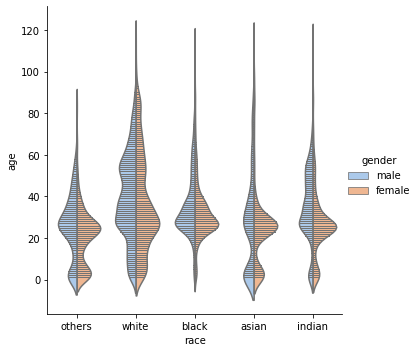

In [21]:
sns.catplot(x="race", y="age", hue="gender", kind="violin", inner="stick",
            split=True, palette="pastel", data=df)  # plot visualizing features


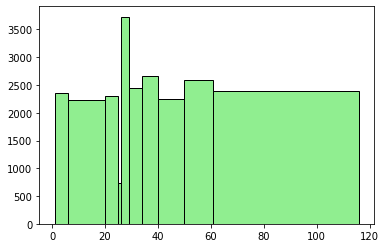

In [22]:
# equal frequency binning
def equalFrequencyDiscretiser(data, nbin):
    return np.interp(np.linspace(0, len(data), nbin + 1), np.arange(len(data)), np.sort(data))


# visualizing binning
n, bins, patches = plt.hist(df.age, equalFrequencyDiscretiser(
    df.age, 10), color='lightgreen', edgecolor='black')
plt.show()


Discretization is the process of converting continuous variables, models, or functions to discrete form. We accomplish this by generating a series of contiguous intervals (or bins) that span the desired variable/model/function. Mathematical problems with continuous data have an infinite number of degrees of freedom (DoF). Because our calculations cannot go on indefinitely, such a problem would necessitate having limited degrees of freedom (DoF). Because of their infinite degrees of freedom, continuous features have a lower chance of correlating with the target variable and may have a complex non-linear relationship. As a result, interpreting such a function may be more difficult. Groups corresponding to the target can be interpreted after a variable has been discretized. The most commonly used discretization approaches are equal-width and equal-frequency, but for our data considering age, equal-frequency is preferable because it improves the value spread, can handle outliers, and can be combined with categorical encoding.

In [23]:
# permutations of gender, race and age 
triplets = [(gender, race, age_range)
            for gender in genders for race in races for age_range in age_ranges]
triplets


[('female', 'asian', '0-10'),
 ('female', 'asian', '10-20'),
 ('female', 'asian', '20-30'),
 ('female', 'asian', '30-40'),
 ('female', 'asian', '40-60'),
 ('female', 'asian', '60-80'),
 ('female', 'asian', '80-200'),
 ('female', 'black', '0-10'),
 ('female', 'black', '10-20'),
 ('female', 'black', '20-30'),
 ('female', 'black', '30-40'),
 ('female', 'black', '40-60'),
 ('female', 'black', '60-80'),
 ('female', 'black', '80-200'),
 ('female', 'indian', '0-10'),
 ('female', 'indian', '10-20'),
 ('female', 'indian', '20-30'),
 ('female', 'indian', '30-40'),
 ('female', 'indian', '40-60'),
 ('female', 'indian', '60-80'),
 ('female', 'indian', '80-200'),
 ('female', 'others', '0-10'),
 ('female', 'others', '10-20'),
 ('female', 'others', '20-30'),
 ('female', 'others', '30-40'),
 ('female', 'others', '40-60'),
 ('female', 'others', '60-80'),
 ('female', 'others', '80-200'),
 ('female', 'white', '0-10'),
 ('female', 'white', '10-20'),
 ('female', 'white', '20-30'),
 ('female', 'white', '30-4

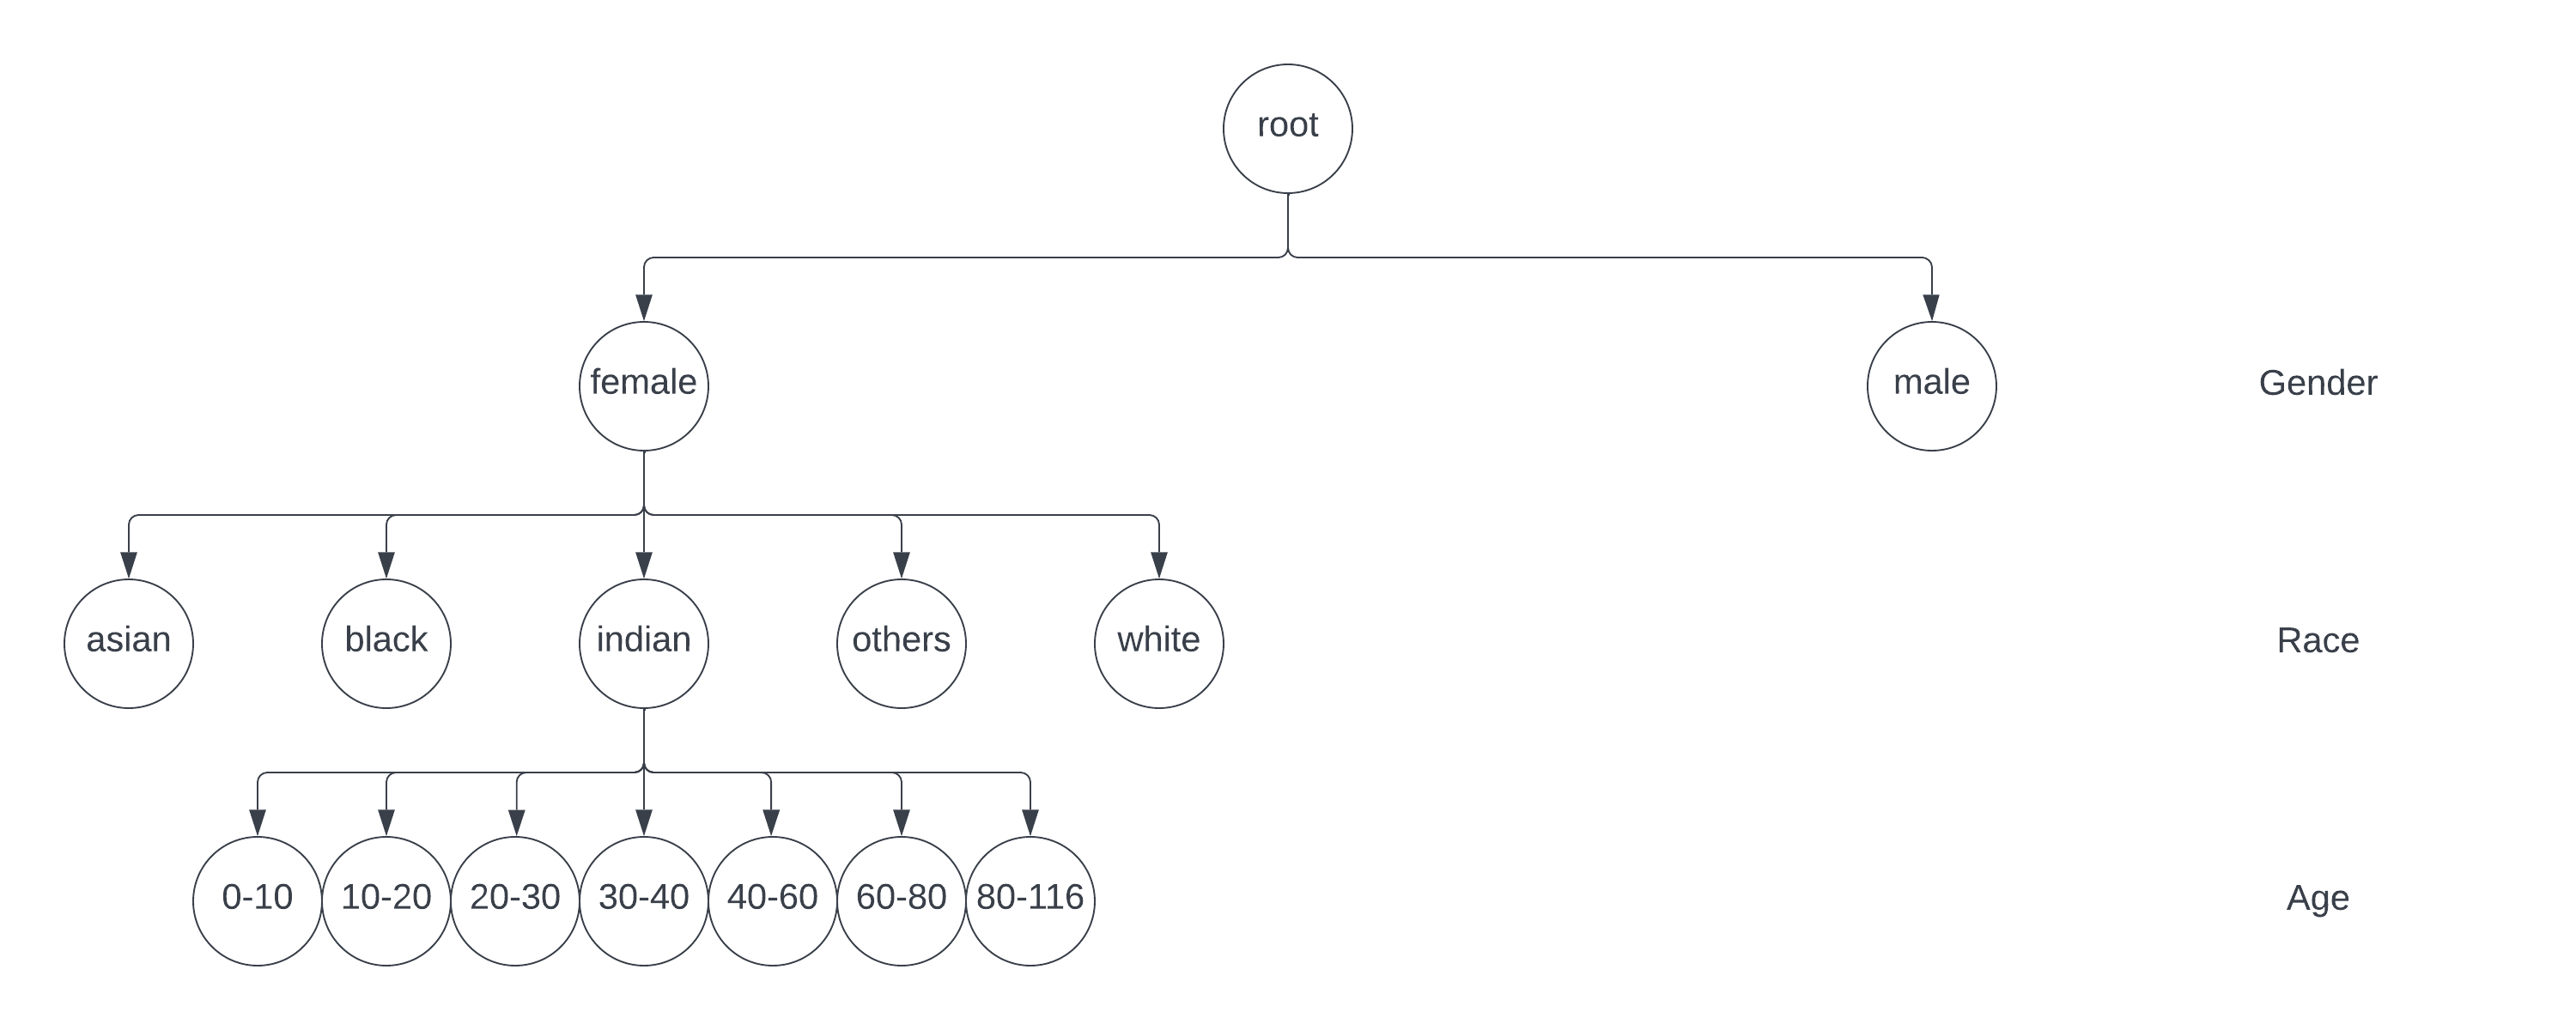

In [24]:
# converting hash array of 0 or 1 to hash string in hex
def hash_array_to_hash_hex(hash_array): 
    hash_array = np.array(hash_array, dtype = np.uint8)
    hash_str = ''.join(str(i) for i in 1 * hash_array.flatten())
    return (hex(int(hash_str, 2)))


# converting hash string in hex to hash values of 0 or 1
def hash_hex_to_hash_array(hash_hex):
    hash_str = int(hash_hex, 16)
    array_str = bin(hash_str)[2:]
    return np.array([i for i in array_str], dtype = np.float32)


# calculating Perceptual Hashing
def p_hash(img_path):
    img = cv2.imread(img_path)
    # resizing image and converting to gray scale
    img = cv2.resize(img, (64, 64))
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    img = np.array(img, dtype = np.float32)
    # calculating dct of image 
    dct = cv2.dct(img)
    # reducing hash length take only 8*8 top-left block 
    # as this block has more information than the rest
    dct_block = dct[: 8, : 8]
    # caclulating mean of dct block excluding first term i.e, dct(0, 0)
    dct_average = (dct_block.mean() * dct_block.size - dct_block[0, 0]) / (dct_block.size - 1)
    # converting dct block to binary values based on dct_average
    dct_block[dct_block < dct_average] = 0.0
    dct_block[dct_block != 0] = 1.0
    # returning hash value
    return hash_array_to_hash_hex(dct_block.flatten())


# calculating hamming distance between image hashes
def img_hash_distance(img1_hash, img2_hash):
    return hamming(hash_hex_to_hash_array(img1_hash), hash_hex_to_hash_array(img2_hash))


# search in image data base
def hash_search(img_path):
    min_distances = list()
    search_img_hash = p_hash(img_path)
    for triplet_data in triplets_data:
        distances = list()
        for img_data in triplets_data[triplet_data]:
            distances.append(img_hash_distance(img_data['imagehash'], search_img_hash))
        min_distances.append(min(distances))
    return triplets[min_distances.index(min(min_distances))], min(min_distances)
    
    
# calculating distance between two leaf nodes of tree 
def leaf_distance(triplet1, triplet2):
    gender1, race1, age_range1 = triplet1
    gender2, race2, age_range2 = triplet2
    return abs(age_ranges.index(age_range2) - age_ranges.index(age_range1)) + abs(genders.index(gender2) - genders.index(gender1)) + 1
    

In [25]:
# calculating hashes for and creating a database for further searches
triplets_data = dict()

for triplet in triplets:
    gender, race, age_range = triplet
    start_age, end_age = age_range.split('-')
    triplets_data[triplet] = list()
    for filepath in df.query(f'age >= {start_age} & age < {end_age} & gender == @gender & race == @race')['filepath']:
        triplets_data[triplet].append({
            'filepath': filepath,
            'imagehash': p_hash(filepath)
        })

triplets[0], triplets_data[triplets[0]]


(('female', 'asian', '0-10'),
 [{'filepath': '../input/utkface-new/UTKFace/5_1_2_20161219195855851.jpg.chip.jpg',
   'imagehash': '0xc0fe0fc2a5c738ce'},
  {'filepath': '../input/utkface-new/UTKFace/3_1_2_20161219211533669.jpg.chip.jpg',
   'imagehash': '0xad8a0df2c3906c90'},
  {'filepath': '../input/utkface-new/UTKFace/5_1_2_20161219192039498.jpg.chip.jpg',
   'imagehash': '0x91bf573757ff7f7f'},
  {'filepath': '../input/utkface-new/UTKFace/4_1_2_20161219190919019.jpg.chip.jpg',
   'imagehash': '0x95552e52d4cf326d'},
  {'filepath': '../input/utkface-new/UTKFace/4_1_2_20161219190541762.jpg.chip.jpg',
   'imagehash': '0x9d417a5f978bbf6d'},
  {'filepath': '../input/utkface-new/UTKFace/5_1_2_20161219200433267.jpg.chip.jpg',
   'imagehash': '0x95ed125793d03e4f'},
  {'filepath': '../input/utkface-new/UTKFace/4_1_2_20161219142249665.jpg.chip.jpg',
   'imagehash': '0x9d29e01ec769d56d'},
  {'filepath': '../input/utkface-new/UTKFace/3_1_2_20161219141659416.jpg.chip.jpg',
   'imagehash': '0xfd0942

In [26]:
!wget 'https://upload.wikimedia.org/wikipedia/commons/d/da/Elizabeth_Holmes_2014_cropped.jpg'
!wget 'https://www.aljazeera.com/wp-content/uploads/2021/09/Picture-Nikhil-Kamath-Co-founder-True-Beacon-and-Zerodha-e1631422463564.jpg'


--2022-03-08 22:23:38--  https://upload.wikimedia.org/wikipedia/commons/d/da/Elizabeth_Holmes_2014_cropped.jpg
Resolving upload.wikimedia.org (upload.wikimedia.org)... 208.80.154.240, 2620:0:861:ed1a::2:b
Connecting to upload.wikimedia.org (upload.wikimedia.org)|208.80.154.240|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 126931 (124K) [image/jpeg]
Saving to: ‘Elizabeth_Holmes_2014_cropped.jpg’

Elizabeth_Holmes_20 100%[===================>] 123.96K   755KB/s    in 0.2s    

2022-03-08 22:23:39 (755 KB/s) - ‘Elizabeth_Holmes_2014_cropped.jpg’ saved [126931/126931]

--2022-03-08 22:23:40--  https://www.aljazeera.com/wp-content/uploads/2021/09/Picture-Nikhil-Kamath-Co-founder-True-Beacon-and-Zerodha-e1631422463564.jpg
Resolving www.aljazeera.com (www.aljazeera.com)... 184.29.223.121, 2600:1402:2000:198::2392, 2600:1402:2000:1a3::2392
Connecting to www.aljazeera.com (www.aljazeera.com)|184.29.223.121|:443... connected.
HTTP request sent, awaiting response... 20

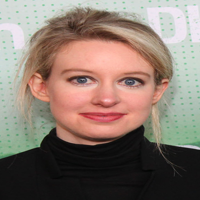

predicted: ('female', 'black', '30-40'), actual: ('female', 'white', '30-40'), hash_distance: 0.25, leaf_distance: 1


In [27]:
display(Image.open('./Elizabeth_Holmes_2014_cropped.jpg').resize((200, 200)))
actual = ('female', 'white', '30-40')
predicted, hash_distance = hash_search('./Elizabeth_Holmes_2014_cropped.jpg')
print(f"predicted: {predicted}, actual: {actual}, hash_distance: {hash_distance}, leaf_distance: {leaf_distance(actual, predicted)}")


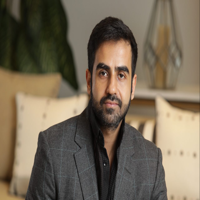

predicted: ('male', 'others', '0-10'), actual: ('male', 'indian', '30-40'), hash_distance: 0.25, leaf_distance: 4


In [28]:
display(Image.open(
    './Picture-Nikhil-Kamath-Co-founder-True-Beacon-and-Zerodha-e1631422463564.jpg').resize((200, 200)))
actual = ('male', 'indian', '30-40')
predicted, distance = hash_search(
    './Picture-Nikhil-Kamath-Co-founder-True-Beacon-and-Zerodha-e1631422463564.jpg')
print(f"predicted: {predicted}, actual: {actual}, hash_distance: {hash_distance}, leaf_distance: {leaf_distance(actual, predicted)}")
